# Library import

In [2]:
import os
import subprocess
import time

import yaml
from sklearn.model_selection import GroupKFold

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn

from pathlib import Path
import json
from collections import defaultdict, Counter
import random
import random
import shutil
from tqdm import tqdm
import zipfile
from collections import Counter

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.57 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.6/8062.4 GB disk)


# Path

In [4]:
COCO_JSON_NM = 'COCO_annotations_new.json'
OUT_COCO_JSON_NM = 'mod_COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
TRAIN_NM = 'train'
VAL_NM = 'val'
TEST_NM = 'test'
LABEL_NM = 'labels'
YAML = 'dataset.yaml'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
yolo_dataset_pth = Path('/kaggle/input/yolodataset-xview')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM

train_img = yolo_dataset_pth / TRAIN_NM / OUT_IMAGE_FLDR_NM
val_img = yolo_dataset_pth / VAL_NM / OUT_IMAGE_FLDR_NM
test_img = yolo_dataset_pth / TEST_NM / OUT_IMAGE_FLDR_NM
train_txt = yolo_dataset_pth / TRAIN_NM / LABEL_NM
val_txt = yolo_dataset_pth / VAL_NM / LABEL_NM 
test_txt = yolo_dataset_pth / TEST_NM / LABEL_NM  
dataset_yaml = yolo_dataset_pth / YAML

In [7]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

Cartella /kaggle/working pulita.


# Utility

In [ ]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# COCO Preprocessing

In [ ]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Ordina le categorie per ID
    categories = sorted(categories, key=lambda x: x['id'])
    
    # Aggiorna le categorie nel JSON
    data['categories'] = categories

 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [ ]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

### Category Check

In [ ]:
def count_bounding_boxes(json_path):
    """
    Conta il numero di bounding box per ogni categoria in un file COCO JSON.

    Args:
        json_path (str): Percorso del file JSON.

    Returns:
        list: Elenco di tuple con ID categoria, nome categoria e numero di bounding box.
    """
    # Carica il file JSON
    coco_data = load_json(json_path)

    # Estrarre i dati principali
    annotations = coco_data.get("annotations", [])
    categories = coco_data.get("categories", [])

    # Mappare id di categoria ai nomi delle categorie
    category_id_to_name = {category["id"]: category["name"] for category in categories}

    # Contare i bounding box per categoria
    bbox_counts = defaultdict(int)
    for annotation in annotations:
        category_id = annotation["category_id"]
        bbox_counts[category_id] += 1

    # Creare un elenco dei risultati
    results = [
        (cat_id, category_id_to_name.get(cat_id, "Unknown"), count)
        for cat_id, count in bbox_counts.items()
    ]
    
    # Ordinare i risultati in ordine decrescente per numero di bounding box
    results.sort(key=lambda x: x[2], reverse=True)
    
    # Stampare i risultati
    for cat_id, category_name, count in results:
        print(f"Categoria ID {cat_id} ('{category_name}'): {count} bounding box")

In [ ]:
count_bounding_boxes(new_coco_json_pth)

# JSON to YOLO

In [ ]:
def convert_json_to_yolo(json_path, images_dir, output_dir, input_dir, train_dir_out, val_dir_out, test_dir_out, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Carica il file JSON
    with open(json_path) as f:
        data = json.load(f)

    # Mappa le classi
    class_mapping = {category['id']: category['name'] for category in data['categories']}
    nc = len(class_mapping)  # Numero di classi

    # Crea le cartelle per il dataset
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    test_images_dir = os.path.join(output_dir, 'test', 'images')

    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')
    
    for dir_path in [train_images_dir, val_images_dir, test_images_dir, train_labels_dir, val_labels_dir, test_labels_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Dividi le immagini in training, validation, and test
    images = data['images']
    random.shuffle(images)
    total_images = len(images)
    
    train_split = int(train_ratio * total_images)
    val_split = int((train_ratio + val_ratio) * total_images)

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    # Funzione per copiare le immagini in una cartella specifica
    def copy_images(image_list, target_dir):
        for image in tqdm(image_list, desc=f"Copying images to {target_dir}", unit="image"):
            src_path = os.path.join(images_dir, image['file_name'])
            dst_path = os.path.join(target_dir, image['file_name'])
            shutil.copy(src_path, dst_path)

    # Copia le immagini nelle rispettive cartelle
    copy_images(train_images, train_images_dir)
    copy_images(val_images, val_images_dir)
    copy_images(test_images, test_images_dir)

    # Converte le annotazioni in formato YOLO e salva nei file di testo
    def convert_annotations(image, annotations, target_dir):
        image_id = image['id']
        image_width = image['width']
        image_height = image['height']
        image_name = image['file_name']

        label_file_path = os.path.join(target_dir, f"{image_name.replace('.jpg', '.txt')}")
        label_dir = os.path.dirname(label_file_path)

        # Crea la cartella se non esiste
        os.makedirs(label_dir, exist_ok=True)

        with open(label_file_path, 'w') as label_file:
            for annotation in annotations:
                if annotation['image_id'] == image_id:
                    category_id = annotation['category_id']
                    xmin, ymin, xmax, ymax = annotation['bbox']

                    # Normalizza le coordinate
                    x_center = (xmin + xmax) / 2 / image_width
                    y_center = (ymin + ymax) / 2 / image_height
                    width = (xmax - xmin) / image_width
                    height = (ymax - ymin) / image_height

                    # Scrivi nel file di annotazione
                    label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

    # Converte le annotazioni per ogni immagine e le salva nelle cartelle appropriate
    def process_images(image_list, target_dir, label_target_dir):
        for image in tqdm(image_list, desc=f"Converting annotations", unit="image"):
            annotations = [annotation for annotation in data['annotations'] if annotation['image_id'] == image['id']]
            convert_annotations(image, annotations, label_target_dir)

    # Processa le immagini per training, validation e test
    process_images(train_images, 'train', train_labels_dir)
    process_images(val_images, 'val', val_labels_dir)
    process_images(test_images, 'test', test_labels_dir)
        
    # Crea il file YAML per YOLO
    yaml_content = f"""path: {input_dir}
train: {train_dir_out}  # train images
val: {val_dir_out}  # val images
test: {test_dir_out}  # test images

# Classes
nc: {nc}  # number of classes
names:
"""
    # Aggiungi le classi al file YAML
    for idx, class_name in class_mapping.items():
        yaml_content += f"  {int(idx)}: {class_name}\n"  # Assicurati che l'indice sia numerico senza virgolette

    # Scrivi il file YAML
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as yaml_file:
        yaml_file.write(yaml_content.strip())

    print("Conversione e split completati.")

In [ ]:
convert_json_to_yolo(
    json_path=new_coco_json_pth,
    images_dir=img_fldr,
    output_dir=out_dataset_pth,
    input_dir=yolo_dataset_pth,
    train_dir_out=train_img,
    val_dir_out=val_img,
    test_dir_out=test_img,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

In [ ]:
# Nome del file zip da creare
zip_file_name = "YOLO_dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "test",
    "train",
    "val",
    "dataset.yaml",
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, out_dataset_pth)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

## Check Yaml

In [ ]:
def analyze_yolo_dataset(yaml_path):
    # Carica il file YAML
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    # Estraggo le informazioni dal file YAML
    base_path = data['path']
    sets = ['train', 'val', 'test']
    stats = {}
    
    total_images = 0
    total_bboxes = Counter()
    class_names = data['names']

    for dataset_set in sets:
        images_path = os.path.join(base_path, dataset_set)
        labels_path = os.path.join(base_path, dataset_set, 'labels')

        # Controlla se le directory esistono
        if not os.path.exists(images_path) or not os.path.exists(labels_path):
            print(f"Directory per il set '{dataset_set}' non trovata.")
            continue

        # Conta immagini
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
        num_images = len(image_files)
        total_images += num_images
        
        stats[dataset_set] = {"images": num_images, "bbox": Counter()}

        # Conta bounding box con tqdm
        print(f"Analizzando {dataset_set}...")
        for label_file in tqdm(os.listdir(labels_path), desc=f"Contando bbox in {dataset_set}", unit="file"):
            label_path = os.path.join(labels_path, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = line.split()[0]  # La classe è il primo elemento della riga
                    stats[dataset_set]["bbox"][class_id] += 1
                    total_bboxes[class_id] += 1

    return stats, total_images, total_bboxes, class_names

# Funzione per mostrare i risultati con le percentuali calcolate per set
def print_stats(stats, total_images, total_bboxes, class_names):
    print("\n--- ANALISI COMPLESSIVA ---")
    print(f"Totale immagini: {total_images}")
    print(f"Distribuzione complessiva delle categorie:")
    
    # Ordina le classi in base al numero di bbox, dal più grande al più piccolo
    sorted_bboxes = sorted(total_bboxes.items(), key=lambda x: x[1], reverse=True)
    
    for class_id, count in sorted_bboxes:
        percentage = (count / sum(total_bboxes.values())) * 100
        print(f"  Classe {class_names[int(class_id)]} ({class_id}): {count} bbox ({percentage:.2f}%)")
    
    print("\n--- ANALISI PER SET ---")
    
    total_bboxes_all_sets = 0  # Per calcolare il totale complessivo dei bbox
    for dataset_set, data in stats.items():
        images_percentage = (data['images'] / total_images) * 100 if total_images > 0 else 0
        print(f"\n--- {dataset_set.upper()} ---")
        print(f"Numero di immagini: {data['images']} ({images_percentage:.2f}%)")
        print("Distribuzione categorie:")
        
        # Calcola il totale dei bbox per ogni set
        total_bboxes_in_set = sum(data['bbox'].values())
        total_bboxes_all_sets += total_bboxes_in_set  # Aggiungi al totale complessivo
        
        # Ordina le classi per ogni set in base al numero di bbox
        sorted_set_bboxes = sorted(data['bbox'].items(), key=lambda x: x[1], reverse=True)
        
        for class_id, count in sorted_set_bboxes:
            percentage = (count / total_bboxes_in_set) * 100 if total_bboxes_in_set > 0 else 0
            print(f"  Classe {class_names[int(class_id)]} ({class_id}): {count} bbox ({percentage:.2f}%)")
        
        print("Totale bounding box:", total_bboxes_in_set, f"({(total_bboxes_in_set / sum(total_bboxes.values())) * 100:.2f}%)")

    # Aggiungi la percentuale per il totale complessivo dei bounding box
    print("\n--- TOTALE COMPLESSIVO ---")
    print(f"Totale bounding box: {total_bboxes_all_sets}")

In [ ]:
# Esegui analisi
stats, total_images, total_bboxes, class_names = analyze_yolo_dataset(dataset_yaml)
print_stats(stats, total_images, total_bboxes, class_names)

# YoloV11

In [8]:
# Pretrained Model
model = YOLO('yolo11n.pt') 

# Configurazione del training
results = model.train(
    data=dataset_yaml,     # Path al file YAML del dataset
    epochs=30,             # Numero di epoche
    batch=64,              # Dimensione del batch
    imgsz=640,             # Dimensione delle immagini (640x640)
    lr0=0.01,              # Learning rate iniziale
    lrf=0.1,               # Fattore di decay del learning rate ((riduce da 0.01 a 0.001))
    save=True,             # Salva i pesi migliori
    #optimizer='AdamW',     # Cambia ottimizzatore per una convergenza più stabile
    optimizer = 'SGD',
    momentum=0.9,          # Momentum ottimizzato
    freeze=[0, 1, 2]       # Congela i primi tre livelli (backbone)
    #project='my_model_results'  # si può personalizzare la directory di salvataggio dei pesi
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 68.4MB/s]


Ultralytics 8.3.57 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/yolodataset-xview/dataset.yaml, epochs=30, time=None, patience=100, batch=64, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning /kaggle/input/yolodataset-xview/train/labels... 36712 images, 11847 backgrounds, 0 corrupt: 100%|██████████| 36712/36712 [00:55<00:00, 660.61it/s]

train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1449_960_1280.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_0.jpg: 69 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_1600.jpg: 36 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_1920.jpg: 44 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_2240.jpg: 43 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_2560.jpg: 23 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_320.jpg: 66 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1832_0_640.jpg: 50 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/yolodataset-xview/train/images/img_1896_0_0.jpg: 59 duplicate labels removed

train: WARNING ⚠️ Cache directory /kaggle/input/yolodataset-xview/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/yolodataset-xview/val/labels... 4589 images, 1496 backgrounds, 0 corrupt: 100%|██████████| 4589/4589 [00:05<00:00, 803.56it/s]

val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_1832_0_960.jpg: 33 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_1896_0_1600.jpg: 21 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_1896_0_2560.jpg: 75 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_18_320_1600.jpg: 36 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_2032_0_640.jpg: 26 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_2032_0_960.jpg: 19 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_20_640_1600.jpg: 11 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_223_0_3200.jpg: 5 duplicate labels removed
val: WARNING ⚠️ /kaggle/input/yolodataset-xview/val/images/img_5_320_2240.jpg: 2 duplicate labels removed


val: WARNING ⚠️ Cache directory /kaggle/input/yolodataset-xview/val is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.88G      1.924      1.918      1.445        578        416: 100%|██████████| 574/574 [03:28<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:26<00:00,  1.35it/s]


                   all       4589      48075      0.167      0.171      0.106      0.043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.98G      1.888      1.666      1.428        463        416: 100%|██████████| 574/574 [03:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.41it/s]


                   all       4589      48075      0.202      0.211      0.145     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.93G      1.876      1.612      1.429        594        416: 100%|██████████| 574/574 [03:23<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]


                   all       4589      48075      0.433      0.238       0.19     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.3G      1.854      1.563      1.416        540        416: 100%|██████████| 574/574 [03:23<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.43it/s]


                   all       4589      48075      0.478      0.282      0.239      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.37G      1.831      1.525      1.405        535        416: 100%|██████████| 574/574 [03:23<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


                   all       4589      48075      0.517      0.312      0.277      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.95G      1.812      1.489      1.392        429        416: 100%|██████████| 574/574 [03:26<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]


                   all       4589      48075      0.535       0.31      0.292      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.62G      1.801      1.474      1.387        773        416: 100%|██████████| 574/574 [03:20<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]


                   all       4589      48075      0.561      0.316      0.319      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      10.3G      1.785      1.449      1.378        453        416: 100%|██████████| 574/574 [03:22<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.43it/s]


                   all       4589      48075      0.488      0.359      0.347      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.42G      1.778      1.431      1.372        576        416: 100%|██████████| 574/574 [03:22<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]


                   all       4589      48075      0.565      0.355      0.354      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.69G      1.772       1.42      1.367        382        416: 100%|██████████| 574/574 [03:17<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]


                   all       4589      48075      0.537      0.354      0.362      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.55G      1.767      1.411      1.359        715        416: 100%|██████████| 574/574 [03:23<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]


                   all       4589      48075        0.5      0.373      0.375      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.28G      1.772      1.399      1.363       1494        416:  12%|█▏        | 70/574 [00:25<03:03,  2.74it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      12/30      7.28G      1.772      1.399      1.363       1494        416:  12%|█▏        | 70/574 [00:25<03:05,  2.72it/s]


KeyboardInterrupt: 

In [ ]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt') # carica i pesi salvati (senza si considera il modello dell'ultima epoca)
model.eval()
results = model.val(data=dataset_yaml) 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
results = model.predict(test_img, imgsz=416, conf = 0.25, save = True, project = out_dataset_pth, verbose = False)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



KeyboardInterrupt: 

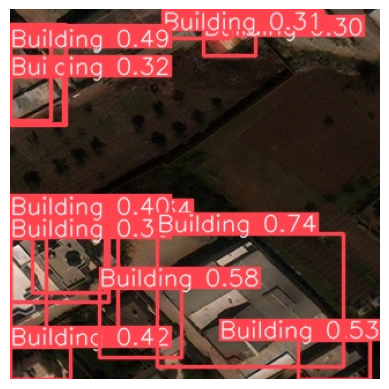

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specifica il percorso dell'immagine
path = "predict/img_102_0_2560.jpg"

# Carica l'immagine
img = mpimg.imread(path)

# Mostra l'immagine
plt.imshow(img)
plt.axis('off')  # Rimuove gli assi
plt.show()